## Paso 1: Carga y preparación de datos.


In [1]:
# ! importamos las packeterias necesarias
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import numpy as np

# ! packeteria que use como auxiliar a pandas por que el archivo si era un poco grande
import polars as pl


# ! configuramos la ruta del archivo 

FILE_PATH = "2019-Nov.csv" # ? configurar 


Dado que el archivo es bastante pesado (casi 10 GB), una opción viable es cargar una muestra significativa de 15,000,000 registros de un total de 67,000,000, en lugar de cargar todo el archivo completo en memoria.

In [2]:
# TODO : CARGAR UNA MUESTRA ALEATORIA DEL ARCHIVO

import random
import polars as pl

NUM_SAMPLES = 12_000_000

with open(FILE_PATH) as f:
    lineas_totales = sum(1 for _ in f) - 1  

lineas_numeros = sorted(random.sample(range(1, lineas_totales + 1), NUM_SAMPLES))

lineas_seleccionadas = []
with open(FILE_PATH) as f:
    header = next(f)
    linea_actual = 0
    target_index = 0

    for i, linea in enumerate(f, 1):  
        if target_index >= NUM_SAMPLES:
            break
        if i == lineas_numeros[target_index]:
            lineas_seleccionadas.append(linea)
            target_index += 1


csv_data = header + "".join(lineas_seleccionadas)
datos = pl.read_csv(csv_data.encode(), infer_schema_length=100)


In [ ]:
# TODO : Cargar todo el archivo

datos = pl.read_csv(FILE_PATH)

## Tratamiento de Valores Nulos

In [3]:
num_rows, _ = datos.shape

null_counts_df = datos.select([
    pl.col(col).is_null().sum().alias(col) for col in datos.columns
])

null_counts_dict = dict(zip(datos.columns, null_counts_df.row(0)))

null_porcentaje = pl.DataFrame({
    "column": list(null_counts_dict.keys()),
    "null_percentage": [count / num_rows for count in null_counts_dict.values()]
})

# ! ordenamos
null_porcentaje = null_porcentaje.sort("null_percentage", descending=True)
print(null_porcentaje)


shape: (9, 2)
┌───────────────┬─────────────────┐
│ column        ┆ null_percentage │
│ ---           ┆ ---             │
│ str           ┆ f64             │
╞═══════════════╪═════════════════╡
│ category_code ┆ 0.324506        │
│ brand         ┆ 0.13656         │
│ user_session  ┆ 3.3333e-7       │
│ event_time    ┆ 0.0             │
│ event_type    ┆ 0.0             │
│ product_id    ┆ 0.0             │
│ category_id   ┆ 0.0             │
│ price         ┆ 0.0             │
│ user_id       ┆ 0.0             │
└───────────────┴─────────────────┘


Los campos que tienen gran porcentaje de valores nullos son "category_code" y "brand", son variables categoricas, por lo que los valores nulos seran cambiados por "desconocido" y hay un porcentaje muy bajo de valores nuloos en "user_session" estos simplemente se eliminaran, son muy pocos.

In [4]:
categoricas_con_nullos_a_eliminar = ["category_code", "brand"]

# ! remplazamos por "desconocido" los valores nullos en category_code y brand
datos = datos.with_columns([
    pl.col(col).fill_null("desconocido") for col in categoricas_con_nullos_a_eliminar
])

# ! eliminamos filas con user_session nulos
datos = datos.filter(pl.col("user_session").is_not_null())



## Eliminar Filas duplicadas

In [5]:
## Eliminar Filas repetidas
datos = datos.unique()

## Añadir Columnas Utiles y conversion de fecha

In [42]:
# TODO : PREPARACION DE DATOS

# ! filtramos solo los eventos view, purchase y cart 
datos = datos.filter(
    (pl.col("event_type") == "view") | 
    (pl.col("event_type") == "purchase") | 
    (pl.col("event_type") == "cart")
)

# ! convertimos el formato de fecha a uno mas facil de trabajar
datos = datos.with_columns(
    pl.col("event_time")
      .str.replace(" UTC", "")  # ! quitamos el UTC de las fechas por que poolars tiene problemas con eso
      .str.strptime(pl.Datetime)  
      .alias("event_time_dt")
)

# Día de la semana
datos = datos.with_columns(
    pl.col("event_time_dt").dt.weekday().alias("weekday_num")
)

# Hora
datos = datos.with_columns(
    pl.col("event_time_dt").dt.hour().alias("hour")
)

# ? añadi una columna binaria y booleana que dice si ese producto se vendio o no
datos = datos.with_columns(
    (pl.col("event_type") == "purchase").alias("is_purchase")
)

datos


event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_time_dt,weekday_num,hour,is_purchase
str,str,i64,i64,str,str,f64,i64,str,datetime[μs],i8,i8,bool
"""2019-11-10 02:58:58 UTC""","""cart""",3900776,2053013552326770905,"""appliances.environment.water_h…","""artel""",85.82,544115638,"""a7c457ea-5ee9-468f-b118-8819fe…",2019-11-10 02:58:58,7,2,false
"""2019-11-12 16:49:12 UTC""","""view""",6600093,2053013554189041997,"""computers.components.memory""","""kingston""",50.3,519280741,"""c4d39629-151e-452b-a10f-8e665c…",2019-11-12 16:49:12,2,16,false
"""2019-11-16 09:46:03 UTC""","""view""",1004839,2053013555631882655,"""electronics.smartphone""","""oppo""",154.42,533008095,"""93e1a2c1-d7c1-4c58-96e3-7af002…",2019-11-16 09:46:03,6,9,false
"""2019-11-24 09:04:24 UTC""","""view""",4804660,2053013554658804075,"""electronics.audio.headphone""","""xiaomi""",34.4,543728526,"""c8d8a81e-d88a-4b08-917e-e93670…",2019-11-24 09:04:24,7,9,false
"""2019-11-15 21:27:02 UTC""","""view""",1004834,2053013555631882655,"""electronics.smartphone""","""samsung""",169.84,526611003,"""841c3d83-81d7-486f-abbd-0ac3ac…",2019-11-15 21:27:02,5,21,false
…,…,…,…,…,…,…,…,…,…,…,…,…
"""2019-11-15 09:19:02 UTC""","""cart""",26500175,2053013563550729061,"""desconocido""","""trollbeads""",140.54,540150460,"""e2708d43-02cf-416a-b9a9-202ed5…",2019-11-15 09:19:02,5,9,false
"""2019-11-12 14:55:37 UTC""","""view""",21409046,2053013561579406073,"""electronics.clocks""","""cover""",217.77,570215050,"""f088389e-15b3-4a28-a49e-fdc7dc…",2019-11-12 14:55:37,2,14,false
"""2019-11-13 13:17:25 UTC""","""view""",12703440,2053013553559896355,"""desconocido""","""cordiant""",58.95,569761768,"""ea04cf87-23fd-4d53-8bcd-94e6e4…",2019-11-13 13:17:25,3,13,false


# Paso 2: Análisis y visualización

## 1 .-  ¿Cuál es la tasa de conversión general (número de compras / número de vistas)?
 

In [9]:
# ? pregunta 1

num_views = datos.filter(pl.col("event_type") == "view").height # ! se cuentan cuantos de los registros corresponden a productos vistos
num_purchase = datos.filter(pl.col("is_purchase")).height # ! cuantos productos fueron vendidios

print(f"Tasa de conversion general : {num_purchase * 100 / num_views} %")

Tasa de conversion general : 1.4394243704503198 %


La tasa de conversión es muy baja: menos del 2% de los productos vistos terminan en una compra. Esto sugiere que los usuarios pasan mucho tiempo explorando productos sin concretar una compra.

## 2. ¿En qué horas del día se concentra la mayoría de las compras? (gráfica por hora)

## Distribuccion por Hora

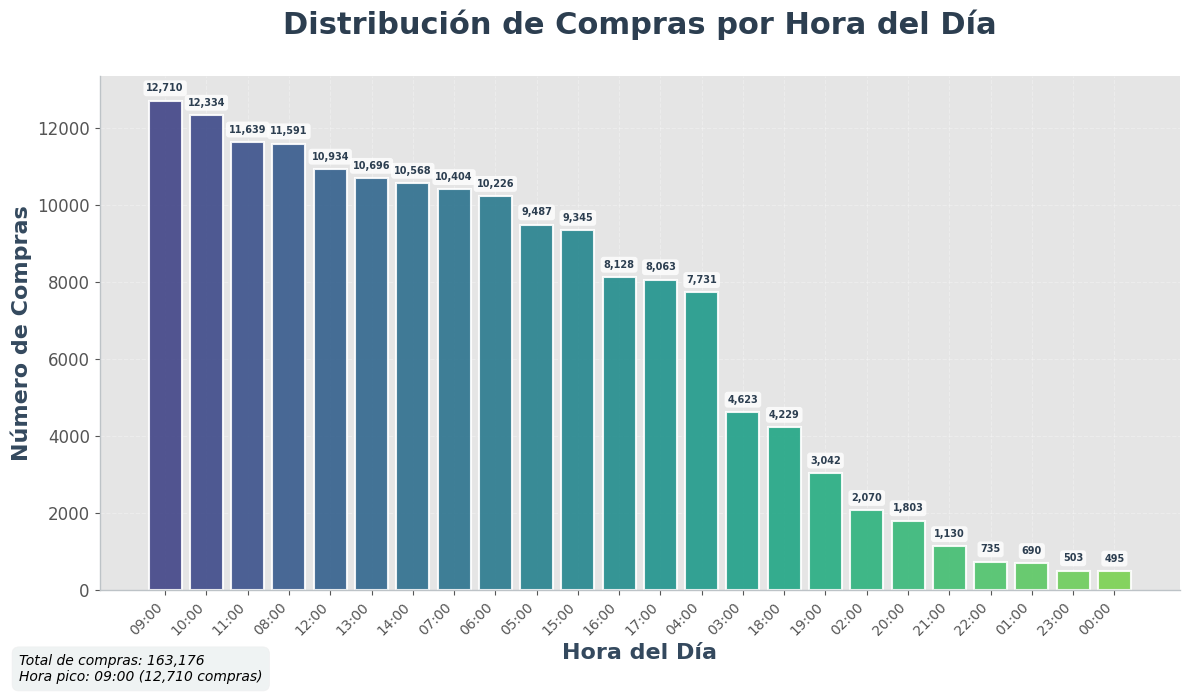

In [41]:
# Agrupación por hora y conteo
conteo_horas = datos.filter(pl.col("is_purchase")).group_by("hour").agg(
    pl.len().alias("conteo")
)

# !Ordenar de manera descendente
conteo_horas = conteo_horas.sort("conteo", descending=True)

import pandas as pd # ? aqui para que funcionen algunas cosas si necesito usar pandas
df_plot = pd.DataFrame({
    'hour': conteo_horas['hour'].to_list(),
    'conteo': conteo_horas['conteo'].to_list()
})

plt.style.use("ggplot")
sns.set_palette("husl")

fig, ax = plt.subplots(figsize=(12, 7))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(df_plot)))

# !Crear el gráfico de barras
bars = ax.bar(range(len(df_plot)), df_plot['conteo'], 
              color=colors, 
              edgecolor='white', 
              linewidth=1.5,
              alpha=0.9)

for bar in bars:
    bar.set_capstyle('round')

plt.title('Distribución de Compras por Hora del Día', 
          fontsize=22, 
          fontweight='bold', 
          pad=30,
          color='#2c3e50')

plt.xlabel('Hora del Día', fontsize=16, fontweight='semibold', color='#34495e')
plt.ylabel('Número de Compras', fontsize=16, fontweight='semibold', color='#34495e')

plt.xticks(range(len(df_plot)), 
           [f"{hour:02d}:00" for hour in df_plot['hour']], 
           rotation=45, 
           fontsize=10,
           ha='right')

plt.yticks(fontsize=12)

max_val = max(df_plot['conteo'])
for i, v in enumerate(df_plot['conteo']):
    ax.text(i, v + max_val*0.015, f'{v:,}', 
            ha='center', va='bottom', 
            fontsize=7, 
            fontweight='bold',
            color='#2c3e50',
            bbox=dict(boxstyle='round,pad=0.3', 
                     facecolor='white', 
                     alpha=0.8,
                     edgecolor='none'))

ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

sns.despine(left=False, bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#bdc3c7')
ax.spines['bottom'].set_color('#bdc3c7')

total_compras = df_plot['conteo'].sum()
hora_pico = df_plot.iloc[0]['hour']
compras_pico = df_plot.iloc[0]['conteo']

info_text = f"Total de compras: {total_compras:,}\nHora pico: {hora_pico:02d}:00 ({compras_pico:,} compras)"
plt.figtext(0.02, 0.02, info_text, 
           fontsize=10, 
           style='italic',
           bbox=dict(boxstyle='round,pad=0.5', 
                    facecolor='#ecf0f1', 
                    alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.show()



## Distribuccion por dia
Otra distribución interesante sería por días de la semana, identificando en cuáles se acumula la mayor cantidad de ventas. 

/tmp/ipykernel_4577/1991701348.py:12: DeprecationWarning: the `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
(Deprecated in version 1.0.0)
  pl.col("weekday_num").replace(mapa_dias, default="Desconocido").alias("weekday")


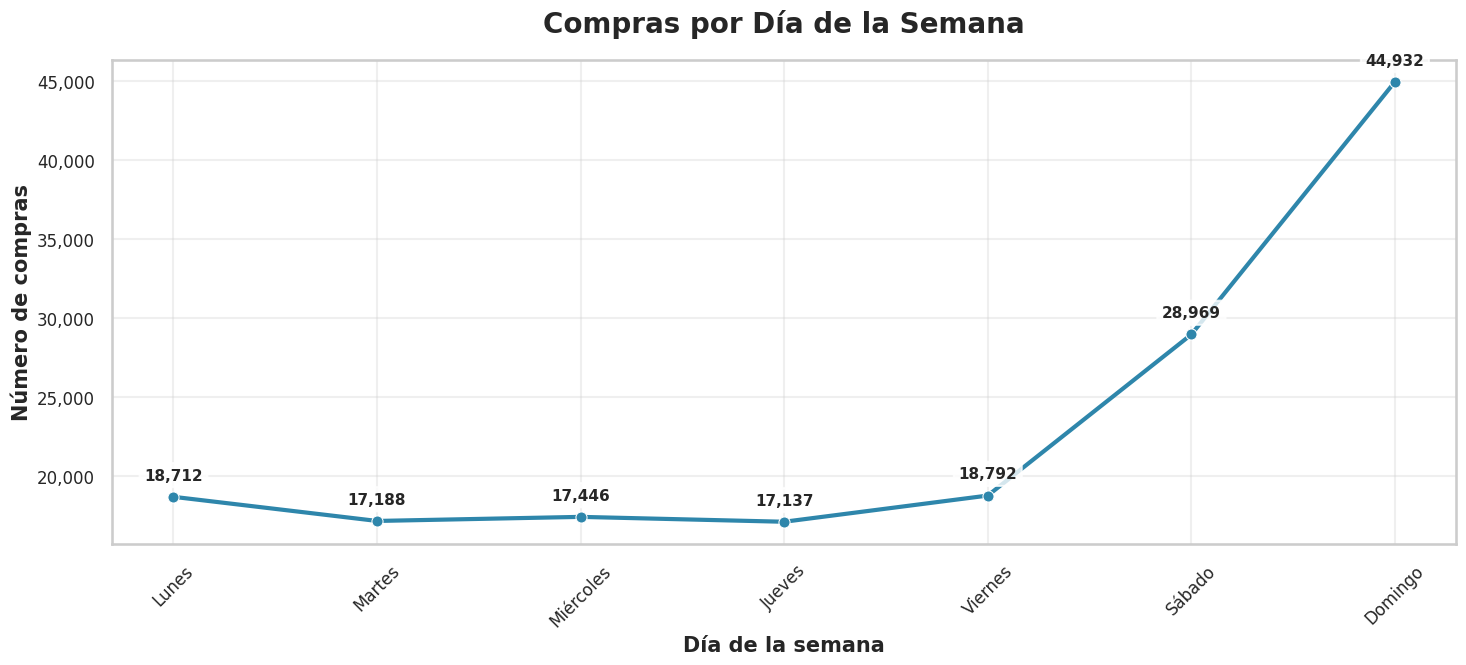

In [14]:
mapa_dias = {
    0: "Lunes", 1: "Martes", 2: "Miércoles", 3: "Jueves",
    4: "Viernes", 5: "Sábado", 6: "Domingo"
}

conteo_dias = (
    datos
    .filter(pl.col("is_purchase") == True) 
    .group_by("weekday_num")
    .agg(pl.len().alias("conteo"))
    .with_columns([
        pl.col("weekday_num").replace(mapa_dias, default="Desconocido").alias("weekday")
    ])
    .sort("weekday_num")
)

conteo_dias_pd = conteo_dias.to_pandas()

orden_dias = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]

sns.set_style("whitegrid")
sns.set_context("talk")

plt.figure(figsize=(15, 7))
ax = sns.lineplot(
    data=conteo_dias_pd, 
    x="weekday", 
    y="conteo", 
    marker="o", 
    linewidth=3, 
    markersize=8,
    color="#2E86AB"
)

ax.set_xticks(range(len(orden_dias)))
ax.set_xticklabels(orden_dias)

for i, (dia, valor) in enumerate(zip(conteo_dias_pd["weekday"], conteo_dias_pd["conteo"])):
    plt.text(i, valor + max(conteo_dias_pd["conteo"]) * 0.02, 
             f'{valor:,}', 
             ha='center', 
             va='bottom', 
             fontsize=11, 
             fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.title("Compras por Día de la Semana", fontsize=20, fontweight='bold', pad=20)
plt.xlabel("Día de la semana", fontsize=15, fontweight='bold')
plt.ylabel("Número de compras", fontsize=15, fontweight='bold')

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

## 3. ¿Qué categorías tienen mayor conversión?


In [9]:
# ! preparo un poco los datos en dos tablas, una de compras por categorias y otra de ventas.
categorias = datos.select(["category_code"]).unique()

vistas_por_categoria = datos.filter(pl.col("event_type") == "view").group_by(["category_code"]).agg([
    pl.len().alias("numero de vistas")
])



vistas_por_categorias = categorias.join(vistas_por_categoria, on="category_code", how="left").with_columns( pl.col("numero de vistas").fill_null(0))



compras_por_categoria = datos.filter(pl.col("event_type") == "purchase").group_by(["category_code"]).agg([
    pl.len().alias("numero de compras")
])

compras_por_categoria =  categorias.join(compras_por_categoria, on="category_code", how="left").with_columns( pl.col("numero de compras").fill_null(0))

compras_por_categoria = compras_por_categoria.sort("numero de compras", descending=True)


vistas_compras_categorias =  compras_por_categoria.join(vistas_por_categorias, on="category_code", how="left")

conversion_categoria = vistas_compras_categorias.with_columns(
    (pl.col("numero de compras") / pl.col("numero de vistas")).alias("conversion")
    
).with_columns( pl.col("conversion").fill_null(0))

conversion_categoria = conversion_categoria.sort("conversion", descending=True)

print(conversion_categoria)


shape: (128, 4)
┌─────────────────────────────┬───────────────────┬──────────────────┬────────────┐
│ category_code               ┆ numero de compras ┆ numero de vistas ┆ conversion │
│ ---                         ┆ ---               ┆ ---              ┆ ---        │
│ str                         ┆ u32               ┆ u32              ┆ f64        │
╞═════════════════════════════╪═══════════════════╪══════════════════╪════════════╡
│ kids.fmcg.diapers           ┆ 136               ┆ 5251             ┆ 0.0259     │
│ electronics.smartphone      ┆ 68023             ┆ 2635518          ┆ 0.02581    │
│ electronics.audio.headphone ┆ 7406              ┆ 292552           ┆ 0.025315   │
│ medicine.tools.tonometer    ┆ 72                ┆ 3681             ┆ 0.01956    │
│ appliances.personal.scales  ┆ 291               ┆ 15665            ┆ 0.018576   │
│ …                           ┆ …                 ┆ …                ┆ …          │
│ apparel.shoes.espadrilles   ┆ 0                 ┆ 237     

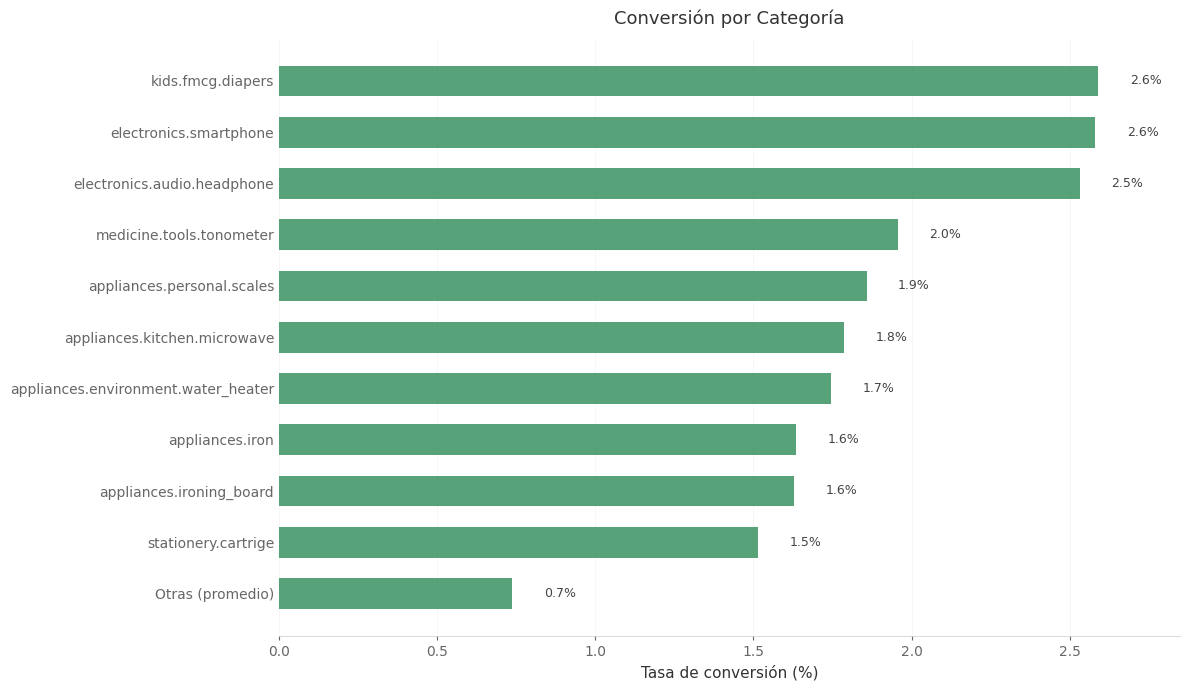

In [ ]:
# Obtener top 10 categorías con mayor conversión
top_10 = conversion_categoria.sort("conversion", descending=True).head(10)

# Obtener el promedio del resto
rest = conversion_categoria.sort("conversion", descending=True).slice(10)
avg_conversion = rest.select(pl.col("conversion").mean()).item()

otras = pl.DataFrame({
    "category_code": ["Otras (promedio)"],
    "conversion": [avg_conversion]
})

df_plot = top_10.select(["category_code", "conversion"]).vstack(otras)

df_plot_pd = df_plot.to_pandas()
df_plot_pd["conversion"] = df_plot_pd["conversion"] * 100

df_plot_pd = df_plot_pd.sort_values("conversion", ascending=True)

plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 7))

bars = ax.barh(
    df_plot_pd["category_code"],
    df_plot_pd["conversion"],
    color='#2E8B57',  
    height=0.6,
    alpha=0.8
)

for i, value in enumerate(df_plot_pd["conversion"]):
    ax.text(value + 0.1, i, f"{value:.1f}%", 
            va='center', ha='left',
            fontsize=9, 
            color='#444444')

ax.set_xlabel("Tasa de conversión (%)", fontsize=11, color='#333333')
ax.set_ylabel("")
ax.set_title("Conversión por Categoría", 
             fontsize=13, 
             weight='normal',
             color='#333333',
             pad=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['bottom'].set_linewidth(0.5)

ax.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5, color='#DDDDDD')
ax.set_axisbelow(True)

ax.tick_params(axis='y', colors="#272626", length=0)
ax.tick_params(axis='x', colors='#666666', length=3)

ax.set_xlim(0, df_plot_pd["conversion"].max() * 1.1)

plt.tight_layout()
plt.show()

## 4. ¿Cuántos usuarios añaden productos al carrito pero no compran? ¿Qué % representan?

In [11]:
usuarios_con_carro = datos.filter(pl.col("event_type") == "cart").select(["user_id"]).unique()
usuarios_con_compras = datos.filter(pl.col("event_type") == "purchase").select(["user_id"]).unique()

usuarios_con_carro_sin_compras = usuarios_con_carro.join(
    usuarios_con_compras,
    on="user_id",
    how="anti" 
) # ! esto es el equivalente en conjuntos a una diferencia 

total_carrito = usuarios_con_carro.height
total_abandono = usuarios_con_carro_sin_compras.height

porcentaje_abandono = (total_abandono / total_carrito) * 100

print(f"Cantidad de usuarios que añaden al carrito y no compran nada son {total_abandono} \n")
print(f"El porcentaje de usuarios que añaden al carrito y no compran nada es del {porcentaje_abandono}")


Cantidad de usuarios que añaden al carrito y no compran nada son 264611 

El porcentaje de usuarios que añaden al carrito y no compran nada es del 80.12372332726729


## Grafica

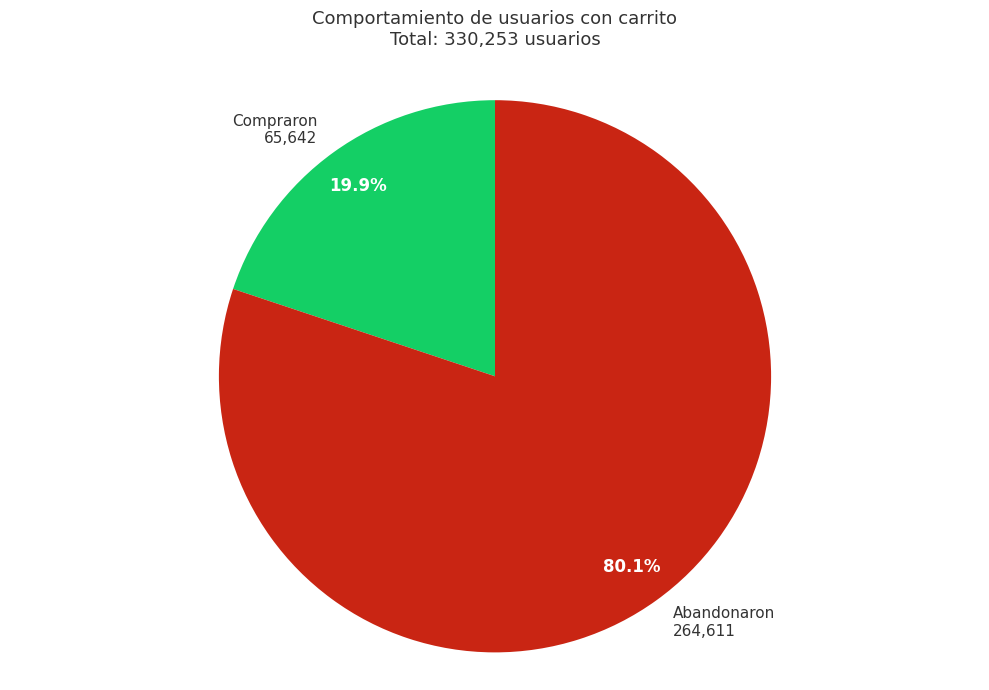

In [36]:
# Cálculo de datos
usuarios_con_carro_y_compras = usuarios_con_carro.join(
    usuarios_con_compras, 
    on="user_id", 
    how="inner"
)

total_con_carrito = usuarios_con_carro.height
compraron = usuarios_con_carro_y_compras.height
abandonaron = total_con_carrito - compraron

valores = [compraron, abandonaron]
etiquetas = [
    f'Compraron\n{compraron:,}', 
    f'Abandonaron\n{abandonaron:,}'
]

colores = ["#14CF65", "#C92513"]  

plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 7))

wedges, texts, autotexts = ax.pie(
    valores, 
    labels=etiquetas,
    colors=colores,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 11, 'color': '#333333'},
    pctdistance=0.85,
    labeldistance=1.1
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

ax.set_title(
    f'Comportamiento de usuarios con carrito\nTotal: {total_con_carrito:,} usuarios',
    fontsize=13,
    weight='normal',
    color='#333333',
    pad=20
)

ax.axis('equal')

plt.tight_layout()
plt.show()


## 5. ¿Qué categorías presentan más abandono del carrito?

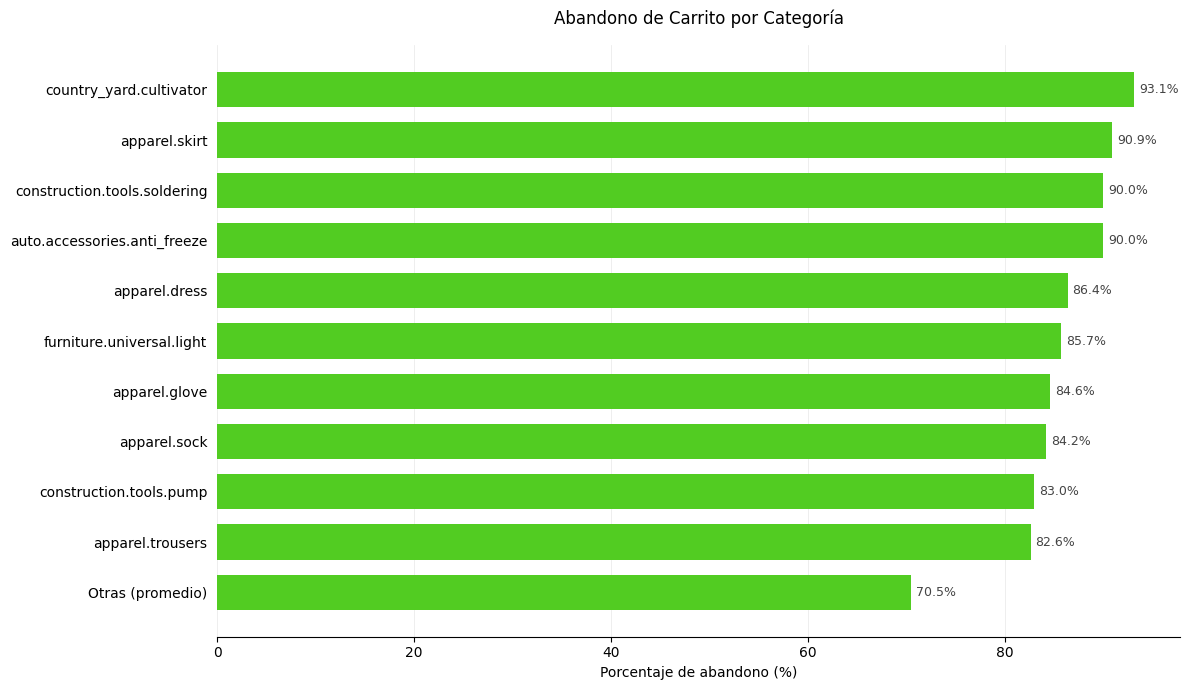

In [37]:
categorias = datos.select(["category_code"]).unique()
categorias_carrito = datos.filter(pl.col("event_type") == "cart").group_by(["category_code"]).agg([
    pl.len().alias("num carrito")
])

categorias_carrito = categorias.join(
    categorias_carrito,
    on="category_code",
    how="left"
).with_columns(pl.col("num carrito").fill_null(0))

categorias_compra = datos.filter(pl.col("event_type") == "purchase").group_by(["category_code"]).agg([
    pl.len().alias("numero de compras")
])

abandono_carrito = categorias_carrito.join(
    categorias_compra,
    on="category_code",
    how="inner"
).with_columns(
    ((1 - (pl.col("numero de compras") / pl.col("num carrito"))) * 100).alias("porcentaje de abandono")
).select(["category_code", "porcentaje de abandono"])

abandono_carrito = abandono_carrito.sort("porcentaje de abandono", descending=True)

top_10 = abandono_carrito.head(10)
otras = abandono_carrito.tail(abandono_carrito.height - 10)
promedio_otras = otras.select(pl.col("porcentaje de abandono").mean()).to_numpy()[0][0]
otras_df = pl.DataFrame({
    "category_code": ["Otras (promedio)"],
    "porcentaje de abandono": [promedio_otras]
})

df_final = pl.concat([top_10, otras_df])

df_final_pd = df_final.to_pandas()


# Versión ultra minimalista
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 7))

# Ordenar datos
df_final_pd = df_final_pd.sort_values("porcentaje de abandono", ascending=True)

# Barras simples
ax.barh(df_final_pd["category_code"],
        df_final_pd["porcentaje de abandono"],
        color="#52CC22",
        height=0.7)

for i, value in enumerate(df_final_pd["porcentaje de abandono"]):
    ax.text(value + 0.5, i, f"{value:.1f}%", 
            va='center', fontsize=9, color='#444')

ax.set_xlabel("Porcentaje de abandono (%)")
ax.set_title("Abandono de Carrito por Categoría", pad=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(left=False)

ax.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# Paso 3: Pensamiento analítico y recomendaciones.

## Insights Interesantes de Comportamiento en Ecommerce

### 1. Horarios de Compra
> **La mayoría de las personas realizan compras entre las 8:00 a.m. y 12:00 a.m.**

Muchos usuarios comienzan su día comprando cosas.

---

### 2. Baja Conversión del Carrito
> **Pocas personas compran realmente los productos que colocan en su carrito, solo un 17% de los articulos en carrito se compran.**

Este dato es contraintuitivo, ya que uno pensaría que agregar un producto al carrito es con intención de compra. Sin embargo, muchos usuarios posiblemente lo usan como una "lista de deseos" o para comparar precios.

---

### 3. Celulares: Alta Tasa de Conversión
> **La categoría de pañales y celulares presentan la mayor tasa de conversión.**

Quienes buscan celulares y pañales suelen hacerlo porque ya tienen una necesidad concreta.

---



## Recomendación de Marketing para Mejorar la Conversión


> **Lanzar campañas los días Domingo o Sabado durante las horas del día entre 9:00 a.m. y 12:00 p.m..**

Esta estrategia aprovecha los momentos en que la mayoría de los usuarios están más con mayor disposición a realizar compras, aumentando así la probabilidad de una alta conversión.


## Segmentación de Usuario para Personalizar Campañas

**Segmentación basada en el horario habitual de compra:**

Dividir a los usuarios según el momento del día en que suelen realizar sus compras (por ejemplo, en la mañana de 9:00 a 12:00 los sabados y domingos) permite personalizar las campañas para que se envíen mensajes promocionales en el momento de mayor actividad de cada segmento.



**Segmentación por Categorías de Alta Conversión:**

Segmentar a los clientes que suelen comprar en categorías con alta tasa de conversión permite enfocar campañas en usuarios con mayor probabilidad de compra.
